# データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 前処理

In [7]:
all_df = pd.concat([train_data,test_data], sort=False).reset_index(drop=True)

Before moving on, make sure that your code returns the output above.  The code above calculates the percentage of female passengers (in **train.csv**) who survived.

Then, run the code below in another code cell:

## 欠損値の処理

### Fare列の欠損値の補完
このコードは、all_df データフレームから Pclass ごとに Fare の平均値を算出し、新しいデータフレーム Fare_mean にまとめるものです。
all_df データフレームの Fare 列の欠損値が Fare_mean データフレームの値で補完され、Fare 列の値がすべて揃った状態になります。

In [8]:
Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()

In [9]:
import pandas as pd

# 'Fare_mean' データフレームに対して 'Fare' 列をリネーム
Fare_mean = Fare_mean.rename(columns={"Fare": "Fare_mean"})

# 'merge' 関数を使用して 'Fare_mean' を 'all_df' にマージ
all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")

# 'Fare' が欠損している場合、'Fare_mean' で置き換える
all_df.loc[all_df["Fare"].isnull(), "Fare"] = all_df["Fare_mean"]

# 'Fare_mean' 列を削除
all_df = all_df.drop("Fare_mean", axis=1)


### 敬称を追加する

In [10]:
#敬称を追加
name_df = all_df["Name"].str.split("[,.]",expand=True, n=2)

In [12]:
# 敬称を含む列を適切な名前にリネームする
name_df = name_df.rename(columns={0: "family_name", 1: "honorific", 2: "name"})

In [13]:
# 各列の要素を文字列に変換してから先頭と末尾の空白を削除
name_df["family_name"] = name_df["family_name"].astype(str).str.strip()
name_df["honorific"] = name_df["honorific"].astype(str).str.strip()
name_df["name"] = name_df["name"].astype(str).str.strip()

In [14]:
all_df = pd.concat([all_df, name_df], axis=1)

In [62]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


### 敬称ごとの年齢の分布を可視化

<Axes: xlabel='honorific', ylabel='Age'>

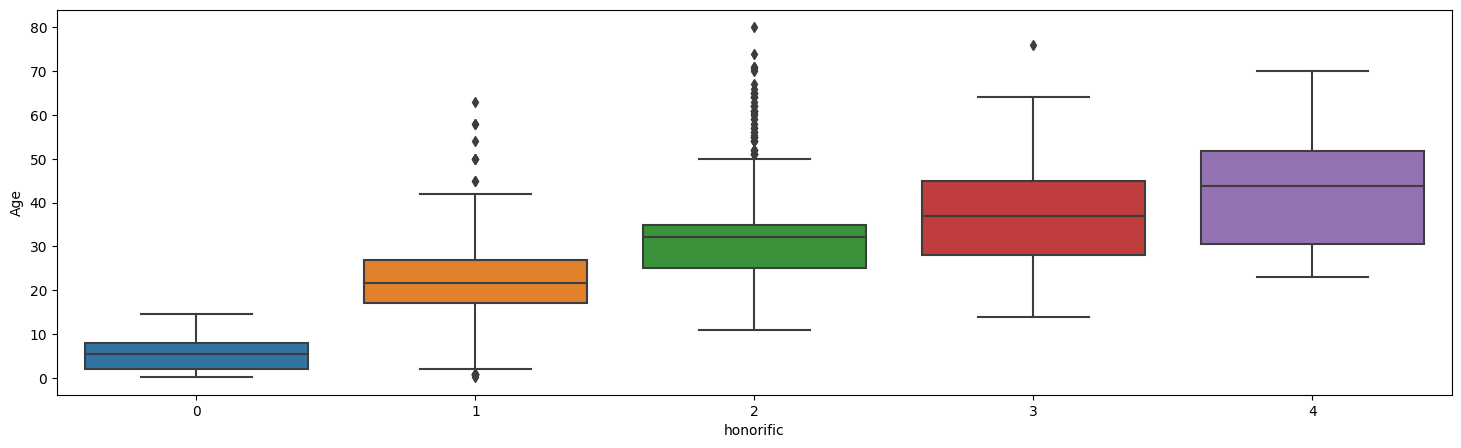

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(18,5))
sns.boxplot(x="honorific", y="Age", data=all_df)

### 号令 (honorific) と生存 (Survived) のグループごとの人数を棒グラフで可視化

In [18]:
train_df = pd.concat([train_data,name_df[0:len(train_data)].reset_index(drop=True)],axis=1)
test_df = pd.concat([test_data,name_df[len(train_data):].reset_index(drop=True)],axis=1)

<Axes: xlabel='honorific'>

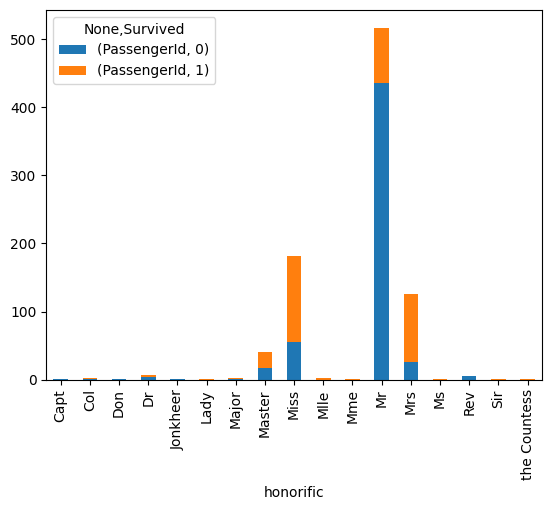

In [19]:
honorific_df = train_df[["honorific","Survived","PassengerId"]].dropna().groupby(["honorific","Survived"]).count().unstack()
honorific_df.plot.bar(stacked=True)

### Titanic データセットの前処理
欠損値の補完、新しい特徴量の作成、不要な列の削除、文字列型の特徴量のカテゴリ整理などを行っています

### 1. 号令 (honorific) ごとに年齢の平均を算出

In [20]:
honorific_age_mean = all_df[["honorific","Age"]].groupby("honorific").mean().reset_index()
honorific_age_mean.columns = ["honorific","honorific_Age"]

### 2. 元のデータフレームに平均年齢列を追加し、欠損値を補完

In [21]:
all_df = pd.merge(all_df,honorific_age_mean,on="honorific",how="left")
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_Age"]
all_df = all_df.drop(["honorific_Age"],axis=1)

### 3. 家族人数 (family_num) と単独フラグ (alone) を作成

In [22]:
all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

In [23]:
all_df.loc[all_df["family_num"] == 0, "alone"] = 1
all_df["alone"] = all_df["alone"].fillna(0)

### 4. 不要な列を削除

In [24]:
all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

### 5. オブジェクト型 (文字列) の列を確認

In [25]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['Sex', 'Embarked', 'honorific'], dtype='object')


### 6. 号令 (honorific) を "Mr", "Miss", "Mrs", "Master" 以外にまとめる

In [26]:
all_df.loc[~((all_df["honorific"] == "Mr") | 
             (all_df["honorific"] == "Miss") |
             (all_df["honorific"] == "Mrs") |
             (all_df["honorific"] == "Master")),
          "honorific"] = "other"

In [27]:
from sklearn.preprocessing import LabelEncoder

### カテゴリ変数を数値に変換する処理

### 1. 性別 (Sex) 列のラベルエンコード

In [28]:
le = LabelEncoder()
le = le.fit(all_df["Sex"])
all_df["Sex"] = le.transform(all_df["Sex"])

### 2. その他のカテゴリ変数のラベルエンコード

In [29]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    if all_df[cat].dtypes == "object":
        le = le.fit(all_df[cat])
        all_df[cat] = le.transform(all_df[cat])

Sex
Embarked
honorific


# モデル生成：LightGBM単体

In [30]:
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_Y = train_df["Survived"]

test_X = all_df[all_df["Survived"].isnull()].drop("Survived",axis=1).reset_index(drop=True)

In [31]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [32]:
import lightgbm as lgb

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)

In [35]:
categories = ["Embarked", "Pclass", "Sex", "honorific","alone"]

In [36]:
lgh_train = lgb.Dataset(X_train,y_train,categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories,reference=lgh_train)

In [37]:
import lightgbm as lgb

# モデルのハイパーパラメータ
lgbm_params = {
    "objective": "binary",
    "random_seed": 1234
}

# データセットの作成
# lgh_train と lgb_eval が事前に定義されていると仮定

# LightGBM モデルの学習
model_lgb = lgb.train(
    lgbm_params,
    lgh_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(10)  # 10 回ごとに評価結果をログ
    ]
)


[LightGBM] [Info] Number of positive: 275, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386236 -> initscore=-0.463162
[LightGBM] [Info] Start training from score -0.463162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

### 敬称と死亡率の関係を可視化

<Axes: >

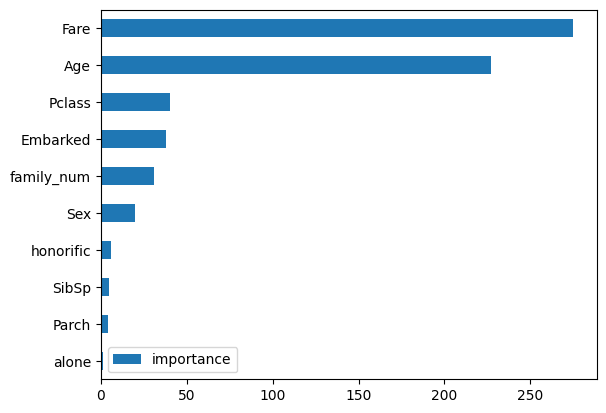

In [38]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending=True)
importance.plot.barh()

### LightGBMモデルを使って、テストデータ (test_X) に対する予測値 (y_pred) を算出する処理を行う

In [39]:
y_pred = model_lgb.predict(test_X, num_iteration=model_lgb.best_iteration)

In [55]:
np.round(y_pred).astype(int)

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [56]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': np.round(y_pred).astype(int)})

In [57]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [58]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [59]:
from IPython.display import FileLink

# ダウンロードリンクを表示
FileLink('./submission.csv')

/kaggle/working/submission.csv